In [ ]:
"""Converts MNIST data to TFRecords file format with Example protos."""
from __future__ import print_function

import argparse
import os.path
import sys
import time
import os

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 


In [1]:
from tensorflow.contrib.learn.python.learn.datasets import mnist

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def convert_to(data_set, name):
    """Converts a dataset to tfrecords."""
    images = data_set.images
    labels = data_set.labels
    num_examples = data_set.num_examples

    rows = images.shape[1]
    cols = images.shape[2]
    depth = images.shape[3]

    filename = os.path.join('/tmp/data', name + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(num_examples):
        image_raw = images[index].tostring()
        example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(rows),
            'width' : _int64_feature(cols),
            'depth' : _int64_feature(depth),
            'label' : _int64_feature(int(labels[index])), 
            'image_raw': _bytes_feature(image_raw)}))
        writer.write(example.SerializeToString())
    writer.close()


# Get the data.
data_sets = mnist.read_data_sets('/tmp/data',
                                   dtype=tf.uint8,
                                   reshape=False,
                                   validation_size=5000)

# Convert to Examples and write the result to TFRecords.
convert_to(data_sets.train, 'train')
convert_to(data_sets.validation, 'validation')
convert_to(data_sets.test, 'test')


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Writing /tmp/data/train.tfrecords


/home/jorge/anaconda3/envs/py3_tf1/lib/python3.6/site-packages/ipykernel/__main__.py:48: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding


Writing /tmp/data/validation.tfrecords
Writing /tmp/data/test.tfrecords


SystemExit: 

/home/jorge/anaconda3/envs/py3_tf1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Read and check TfRecords

In [22]:
def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
          serialized_example,
          # Defaults are not specified since both keys are required.
          features={
              'image_raw': tf.FixedLenFeature([], tf.string),
              'label': tf.FixedLenFeature([], tf.int64),
          })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    print(image)
    image.set_shape(784)
    

    # OPTIONAL: Could reshape into a 28x28 image and apply distortions
    # here.  Since we are not applying any distortions in this
    # example, and the next step expects the image to be flattened
    # into a vector, we don't bother.

    # Convert from [0, 255] -> [-0.5, 0.5] floats.
    image = tf.cast(image, tf.float32) * (1. / 255) - 0.5

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int32)

    return image, label

def inputs(train, batch_size, num_epochs):
    """Reads input data num_epochs times.
    Args:
      train: Selects between the training (True) and validation (False) data.
      batch_size: Number of examples per returned batch.
      num_epochs: Number of times to read the input data, or 0/None to
         train forever.
    Returns:
      A tuple (images, labels), where:
      * images is a float tensor with shape [batch_size, mnist.IMAGE_PIXELS]
        in the range [-0.5, 0.5].
      * labels is an int32 tensor with shape [batch_size] with the true label,
        a number in the range [0, mnist.NUM_CLASSES).
      Note that an tf.train.QueueRunner is added to the graph, which
      must be run using e.g. tf.train.start_queue_runners().
    """
    if not num_epochs: num_epochs = None
    filename = os.path.join('/tmp/data',
                          'train.tfrecords' if train else 'validation.tfrecords')

    with tf.name_scope('input'):
        filename_queue = tf.train.string_input_producer(
            [filename], num_epochs=num_epochs)

        # Even when reading in multiple threads, share the filename
        # queue.
        image, label = read_and_decode(filename_queue)

        # Shuffle the examples and collect them into batch_size batches.
        # (Internally uses a RandomShuffleQueue.)
        # We run this in two threads to avoid being a bottleneck.
        images, sparse_labels = tf.train.shuffle_batch(
            [image, label], batch_size=batch_size, num_threads=2,
            capacity=1000 + 3 * batch_size,
            # Ensures a minimum amount of shuffling of examples.
            min_after_dequeue=1000)

        return images, sparse_labels

Tensor("DecodeRaw_12:0", shape=(?,), dtype=uint8)
7


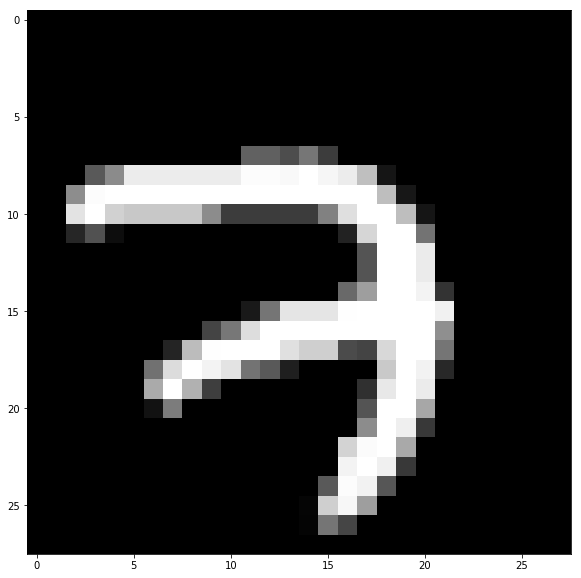

3


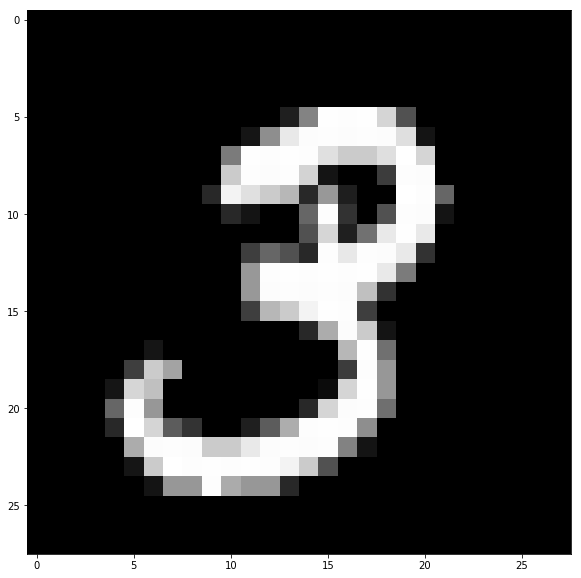

4


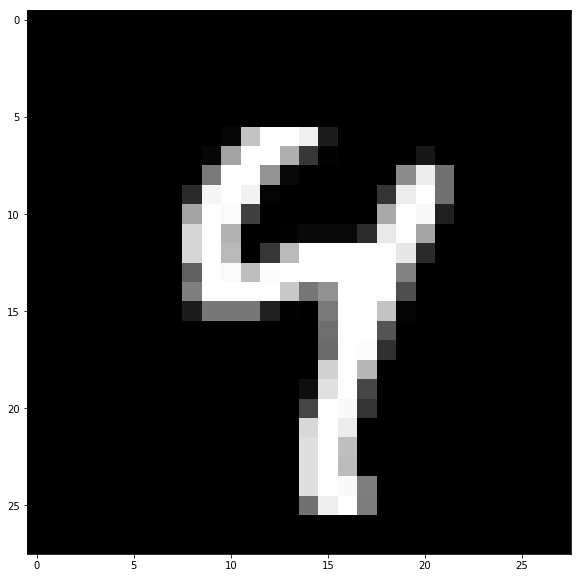

Tensor("DecodeRaw_13:0", shape=(?,), dtype=uint8)
(784,)
Tensor("Cast_27:0", shape=(), dtype=int32)


In [23]:
#Show images
filename = os.path.join('/tmp/data', TRAIN_FILE)
filename_queue = tf.train.string_input_producer([filename], num_epochs=1)
image, target = read_and_decode(filename_queue)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    # Let's read off 3 batches just for example
    for i in range(3):
    
        img, label = sess.run([image, target])
        print(label)
        plt.imshow(np.reshape(img,[28,28]))
        plt.show()

    coord.request_stop()
    coord.join(threads)
    
    
image, label = read_and_decode(filename_queue)
print(image.shape)
print(label)

In [8]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Tell TensorFlow that the model will be built into the default Graph.
with tf.Graph().as_default():
    # Input images and labels.
    images, labels = inputs(train=True, batch_size=256,
                            num_epochs=2)
    
    W = tf.Variable(tf.zeros([784,10]))
    b = tf.Variable(tf.zeros([10]))
    y_pred = tf.nn.softmax(tf.matmul(images,W) + b)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_pred, labels=labels)
    train_op = tf.train.AdamOptimizer(0.01).minimize(loss)

    # The op for initializing the variables.
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())

    # Create a session for running operations in the Graph.
    gpu_options = tf.GPUOptions(allow_growth = True)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

        # Initialize the variables (the trained variables and the
        # epoch counter).
        sess.run(init_op)

        # Start input enqueue threads.
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        try:
            step = 0
            while not coord.should_stop():
                start_time = time.time()
                _, loss_value = sess.run([train_op, loss])
                duration = time.time() - start_time

                # Print an overview fairly often.
                if step % 100 == 0:
                    print('Step %d: loss = %.2f (%.3f sec)' % (step, np.mean(loss_value), duration))
                step += 1
        except tf.errors.OutOfRangeError:
            print('Done training for %d epochs, %d steps.' % (2, step))
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)


Step 0: loss = 2.30 (0.466 sec)
Step 100: loss = 1.89 (0.078 sec)
Step 200: loss = 1.81 (0.081 sec)
Step 300: loss = 1.88 (0.080 sec)
Step 400: loss = 1.86 (0.077 sec)
Done training for 2 epochs, 429 steps.
